### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import os
import cv2
from tensorflow.keras.utils import to_categorical

### Function to extract images and labels

In [2]:
def seperate_images_labels(data_dir, label_indices):
    data = [] # List to store preprocessed images
    labels = [] # List to store corresponding labels
    img_format = ['.jpg', '.png', '.jpeg'] # Supported image formats
    # Iterate through each file in the specified directory
    for img_name in os.listdir(data_dir):
        # Check if the file has a valid image format
        if not any([img_name.endswith(img) for img in img_format]):
            continue
        # Create the full path to the image file
        img_path = os.path.join(data_dir, img_name)
        # Extract the label from the image name based on a specific pattern
        label_name = img_name.split('_')[0]
        label = label_indices[label_name]
        # Read and resize the image using OpenCV
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        # Append the preprocessed image and its label to the respective lists
        data.append(img)
        labels.append(label)
    # Convert the lists to numpy arrays and return
    return np.array(data), np.array(labels)

### Function to create model

In [3]:
class CreateModel:
    def __init__(self, pre_train_model, num_classes=2):
        # Freeze the weights of the pre-trained model
        pre_train_model.trainable = False
        # Get the output of the pre-trained model
        last_output = pre_train_model.output
        # Flatten the output and add additional layers
        x = Flatten()(last_output)
        x = Dense(512, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        # Final output layer with softmax activation for classification
        output = Dense(num_classes, activation='softmax')(x)

        # Define optimizer, learning rate and loss function
        self.model = Model(pre_train_model.input, output)
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
    # Train the model using the fit method
    def fit(self, train_generator, validation_generator, step_size_train, step_size_validation, epochs=20):
        history = self.model.fit(
            train_generator,
            steps_per_epoch=step_size_train,
            epochs=epochs,
            shuffle=False,
            verbose=1,
            validation_data=validation_generator,
            validation_steps=step_size_validation,
        )
        # Return the training history and the trained model
        return history, self.model

### Function to plot accuracy and loss

In [4]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()

### Function to plot confusion matrix

In [5]:
def confusion_matrix(test_generator, y_pred, class_labels=None):
    if class_labels is None:
        class_labels = list(test_generator.class_indices.keys())
        disp = metrics.ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred, display_labels=class_labels, 
                                                               xticks_rotation='vertical', cmap='Blues')
    else:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(test_generator, y_pred, display_labels=class_labels,
                                                               xticks_rotation='vertical', cmap='Blues')
    fig = disp.ax_.get_figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()

### Function to calculate report

In [6]:
def report_model(test_generator, y_pred, class_labels=None):
    if class_labels is None:
        class_labels = list(test_generator.class_indices.keys())
        true_classes = test_generator.classes
        report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
    else:
        report = metrics.classification_report(test_generator, y_pred, target_names=class_labels)
    print(report)

## ACDC Dataset

In [7]:
label_indices = {'clear':0, 'fog':1, 'night':2, 'rain':3, 'snow':4} # Define label indices

training_images, training_labels = seperate_images_labels('ACDC/train', label_indices)
validation_images, validation_labels = seperate_images_labels('ACDC/test', label_indices)
test_images, test_labels = seperate_images_labels('ACDC/test', label_indices)

# Convert labels to one-hot encoding
training_labels = to_categorical(training_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow(
    training_images, training_labels,
    batch_size=batch_size,
    shuffle=True,
    seed=19
)

validation_generator = val_datagen.flow(
    validation_images, validation_labels,
    batch_size=batch_size,
    shuffle=False,
    seed=19
)

test_generator = val_datagen.flow(
    test_images, test_labels,
    batch_size=1,
    shuffle=False,
    seed=19
)

In [8]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // validation_generator.batch_size
step_size_test = test_generator.n // test_generator.batch_size

In [9]:
pre_train_model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3)
)

model = CreateModel(pre_train_model_VGG16, num_classes=training_labels.shape[1])
history_acdc, model_acdc = model.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=20)

Epoch 1/20
31/31 [==============================] - 22s 563ms/step - loss: 1.0668 - acc: 0.5968 - val_loss: 0.6157 - val_acc: 0.7750
Epoch 2/20
31/31 [==============================] - 19s 630ms/step - loss: 0.5318 - acc: 0.8054 - val_loss: 0.5222 - val_acc: 0.7854
Epoch 3/20
31/31 [==============================] - 18s 590ms/step - loss: 0.3483 - acc: 0.8780 - val_loss: 0.4636 - val_acc: 0.8208
Epoch 4/20
31/31 [==============================] - 17s 546ms/step - loss: 0.2972 - acc: 0.8921 - val_loss: 0.3345 - val_acc: 0.8750
Epoch 5/20
31/31 [==============================] - 17s 562ms/step - loss: 0.2650 - acc: 0.9163 - val_loss: 0.4687 - val_acc: 0.8167
Epoch 6/20
31/31 [==============================] - 17s 566ms/step - loss: 0.3073 - acc: 0.8921 - val_loss: 0.3364 - val_acc: 0.8646
Epoch 7/20
31/31 [==============================] - 16s 527ms/step - loss: 0.1770 - acc: 0.9405 - val_loss: 0.3472 - val_acc: 0.8667
Epoch 8/20
31/31 [==============================] - 17s 557ms/step - 

In [10]:
y_pred_tmp = model_acdc.predict(test_generator, step_size_test)
y_pred_acdc = np.argmax(y_pred_tmp, axis=1)

500/500 [==============================] - 8s 14ms/step


In [11]:
# Test model
loss = model_acdc.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

500/500 [==============================] - 8s 15ms/step - loss: 0.3825 - acc: 0.8740
loss test: 0.38
accuracy test: 0.87


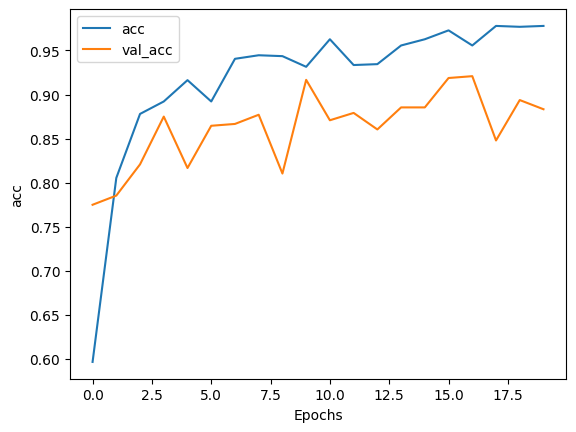

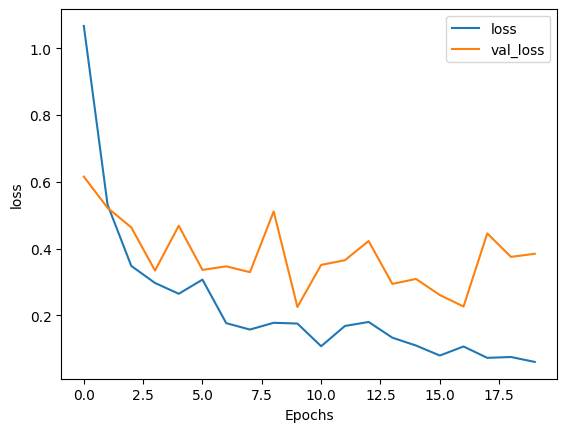

In [12]:
plot_graphs(history_acdc, 'acc')
plot_graphs(history_acdc, 'loss')

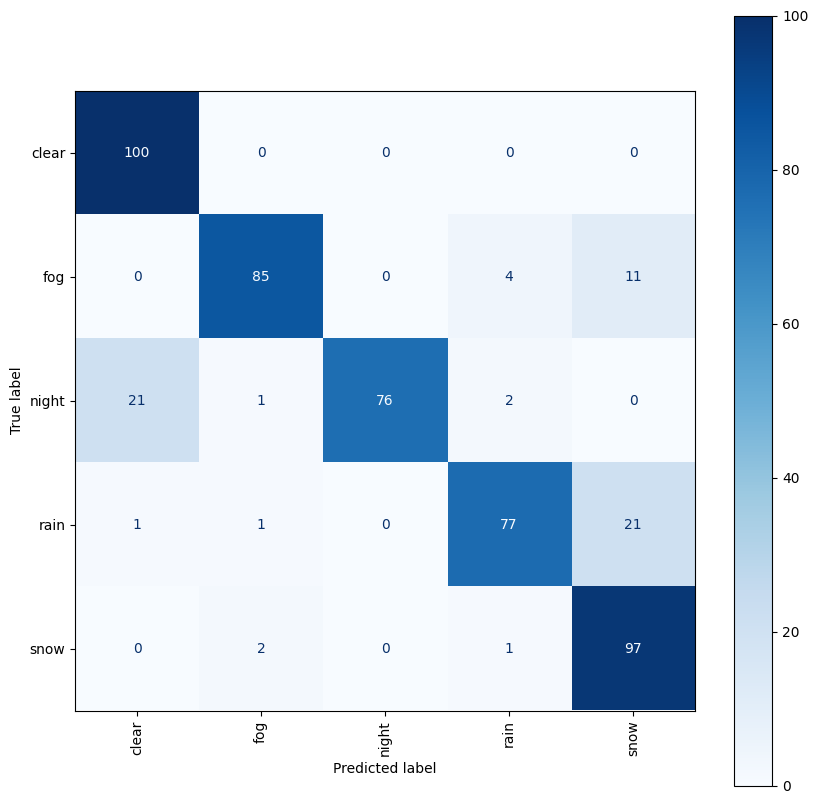

In [13]:
confusion_matrix(np.argmax(test_labels, axis=1), y_pred_acdc, class_labels=label_indices.keys())

In [14]:
report_model(np.argmax(test_labels, axis=1), y_pred_acdc, class_labels=label_indices.keys())

              precision    recall  f1-score   support

       clear       0.82      1.00      0.90       100
         fog       0.96      0.85      0.90       100
       night       1.00      0.76      0.86       100
        rain       0.92      0.77      0.84       100
        snow       0.75      0.97      0.85       100

    accuracy                           0.87       500
   macro avg       0.89      0.87      0.87       500
weighted avg       0.89      0.87      0.87       500


## MWD Dataset

In [15]:
train_data_dir = 'MWD/train'
val_data_dir = 'MWD/test'
test_data_dir = 'MWD/test'

img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=19
)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=19
)

test_generator = val_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=19
)

Found 847 images belonging to 4 classes.
Found 278 images belonging to 4 classes.
Found 278 images belonging to 4 classes.


In [16]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // validation_generator.batch_size
step_size_test = test_generator.n // test_generator.batch_size

In [17]:
pre_train_model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3)
)

model = CreateModel(pre_train_model_VGG16, num_classes=train_generator.num_classes)
history_mwd, model_mwd = model.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=20)

Epoch 1/20
26/26 [==============================] - 26s 985ms/step - loss: 1.0504 - acc: 0.5637 - val_loss: 0.6167 - val_acc: 0.8281
Epoch 2/20
26/26 [==============================] - 15s 583ms/step - loss: 0.5651 - acc: 0.7957 - val_loss: 0.4567 - val_acc: 0.8242
Epoch 3/20
26/26 [==============================] - 16s 598ms/step - loss: 0.4182 - acc: 0.8594 - val_loss: 0.4913 - val_acc: 0.8242
Epoch 4/20
26/26 [==============================] - 16s 622ms/step - loss: 0.3231 - acc: 0.9075 - val_loss: 0.3415 - val_acc: 0.8789
Epoch 5/20
26/26 [==============================] - 18s 680ms/step - loss: 0.2244 - acc: 0.9255 - val_loss: 0.2676 - val_acc: 0.8906
Epoch 6/20
26/26 [==============================] - 18s 706ms/step - loss: 0.1953 - acc: 0.9399 - val_loss: 0.2307 - val_acc: 0.9219
Epoch 7/20
26/26 [==============================] - 19s 736ms/step - loss: 0.1545 - acc: 0.9531 - val_loss: 0.2103 - val_acc: 0.9180
Epoch 8/20
26/26 [==============================] - 16s 609ms/step - 

In [18]:
y_pred_tmp = model_mwd.predict(test_generator, step_size_test)
y_pred_mwd = np.argmax(y_pred_tmp, axis=1)

278/278 [==============================] - 4s 14ms/step


In [19]:
# Test model
loss = model_mwd.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

278/278 [==============================] - 4s 14ms/step - loss: 0.2156 - acc: 0.9460
loss test: 0.22
accuracy test: 0.95


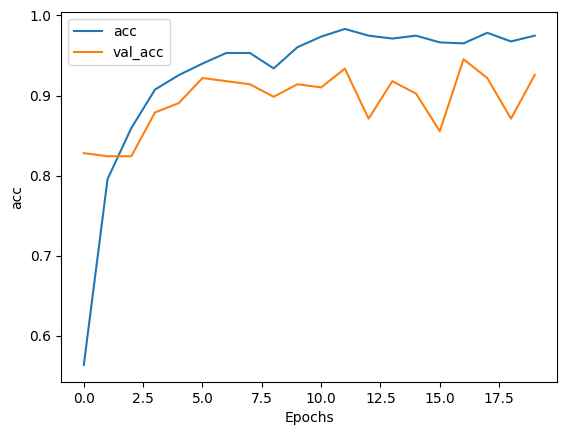

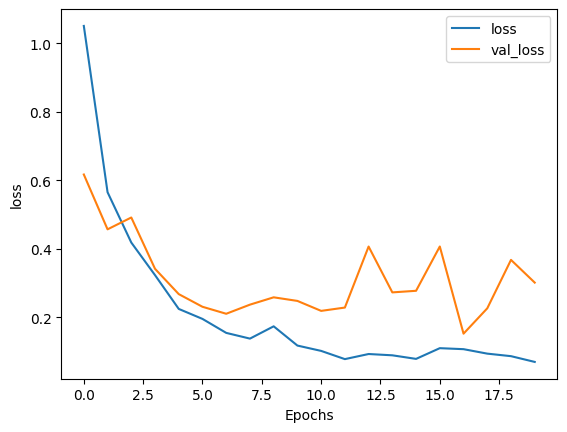

In [20]:
plot_graphs(history_mwd, 'acc')
plot_graphs(history_mwd, 'loss')

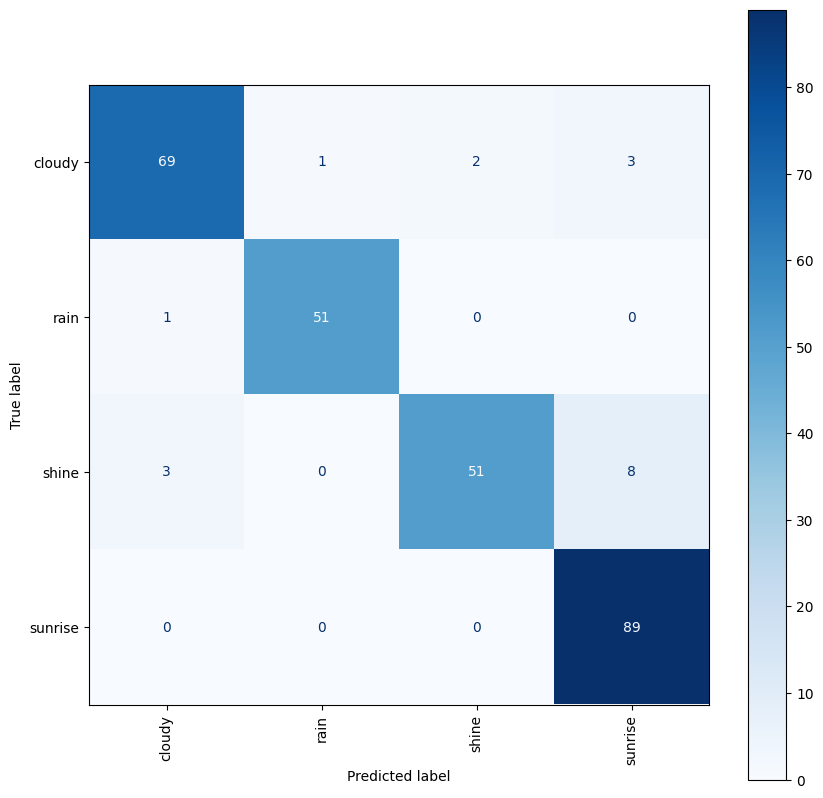

In [21]:
confusion_matrix(test_generator, y_pred_mwd)

In [22]:
report_model(test_generator, y_pred_mwd)

              precision    recall  f1-score   support

      cloudy       0.95      0.92      0.93        75
        rain       0.98      0.98      0.98        52
       shine       0.96      0.82      0.89        62
     sunrise       0.89      1.00      0.94        89

    accuracy                           0.94       278
   macro avg       0.94      0.93      0.94       278
weighted avg       0.94      0.94      0.93       278


## Syndrone Dataset

In [23]:
label_indices = {'ClearNight':0, 'ClearNoon':1, 'HardRainNoon':2, 'MidFoggyNoon':3}

training_images, training_labels = seperate_images_labels('syndrone/train', label_indices)
validation_images, validation_labels = seperate_images_labels('syndrone/test', label_indices)
test_images, test_labels = seperate_images_labels('syndrone/test', label_indices)

# Convert labels to one-hot encoding
training_labels = to_categorical(training_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow(
    training_images, training_labels,
    batch_size=batch_size,
    shuffle=True,
    seed=19
)

validation_generator = val_datagen.flow(
    validation_images, validation_labels,
    batch_size=batch_size,
    shuffle=False,
    seed=19
)

test_generator = val_datagen.flow(
    test_images, test_labels,
    batch_size=1,
    shuffle=False,
    seed=19
)

In [24]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // validation_generator.batch_size
step_size_test = test_generator.n // test_generator.batch_size

In [25]:
pre_train_model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3)
)

model = CreateModel(pre_train_model_VGG16, num_classes=training_labels.shape[1])
history_syndrone, model_syndrone = model.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=20)

Epoch 1/20
25/25 [==============================] - 15s 562ms/step - loss: 0.9929 - acc: 0.5625 - val_loss: 0.5428 - val_acc: 0.8333
Epoch 2/20
25/25 [==============================] - 16s 630ms/step - loss: 0.5686 - acc: 0.7875 - val_loss: 0.4907 - val_acc: 0.7865
Epoch 3/20
25/25 [==============================] - 15s 626ms/step - loss: 0.4349 - acc: 0.8263 - val_loss: 0.3957 - val_acc: 0.8464
Epoch 4/20
25/25 [==============================] - 14s 548ms/step - loss: 0.3617 - acc: 0.8625 - val_loss: 0.4020 - val_acc: 0.8516
Epoch 5/20
25/25 [==============================] - 15s 586ms/step - loss: 0.3571 - acc: 0.8575 - val_loss: 0.3554 - val_acc: 0.8464
Epoch 6/20
25/25 [==============================] - 14s 547ms/step - loss: 0.2501 - acc: 0.9150 - val_loss: 0.3367 - val_acc: 0.8698
Epoch 7/20
25/25 [==============================] - 15s 622ms/step - loss: 0.2702 - acc: 0.8975 - val_loss: 0.2901 - val_acc: 0.8802
Epoch 8/20
25/25 [==============================] - 16s 655ms/step - 

In [26]:
y_pred_tmp = model_syndrone.predict(test_generator, step_size_test)
y_pred_syndrone = np.argmax(y_pred_tmp, axis=1)

400/400 [==============================] - 5s 12ms/step


In [27]:
# Test model
loss = model_syndrone.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

400/400 [==============================] - 6s 14ms/step - loss: 0.2772 - acc: 0.9075
loss test: 0.28
accuracy test: 0.91


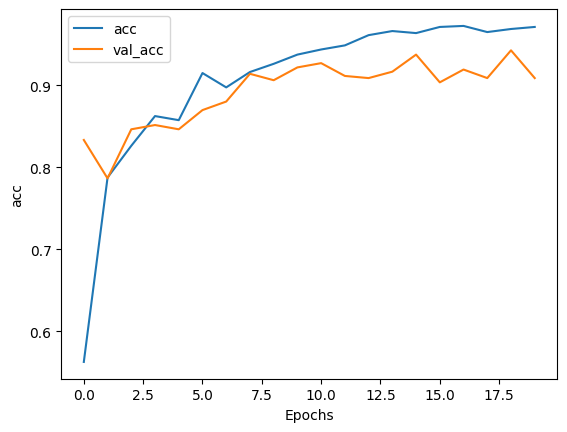

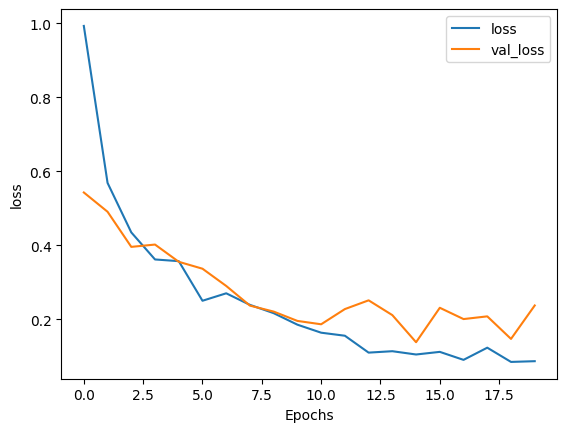

In [28]:
plot_graphs(history_syndrone, 'acc')
plot_graphs(history_syndrone, 'loss')

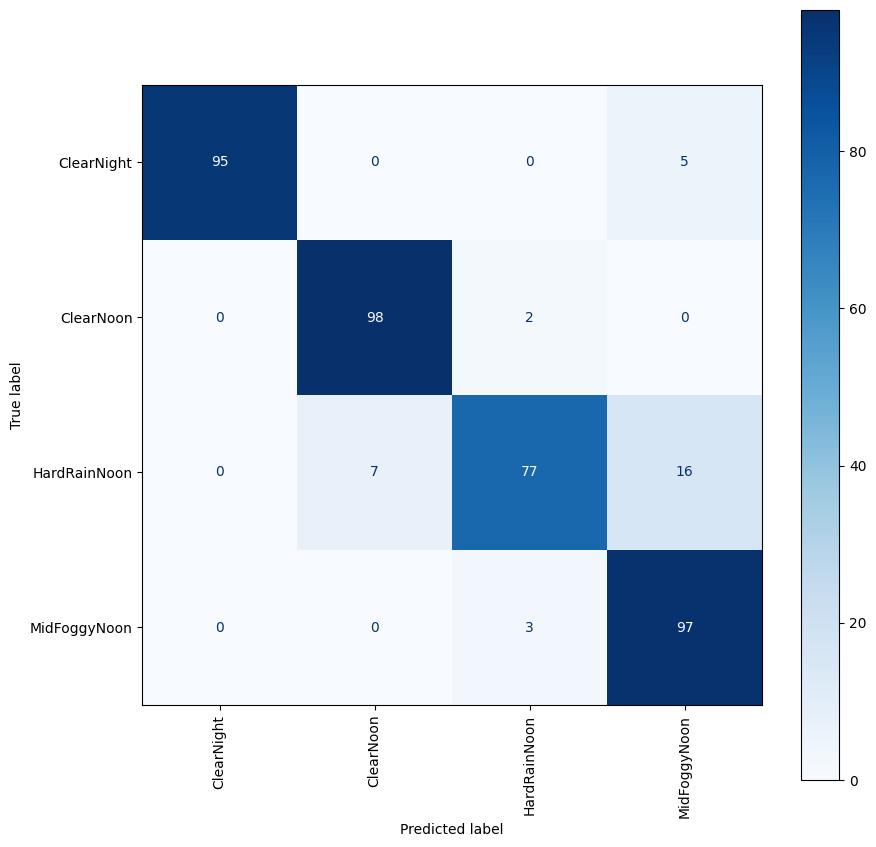

In [29]:
confusion_matrix(np.argmax(test_labels, axis=1), y_pred_syndrone, class_labels=label_indices.keys())

In [30]:
report_model(np.argmax(test_labels, axis=1), y_pred_syndrone, class_labels=label_indices.keys())

              precision    recall  f1-score   support

  ClearNight       1.00      0.95      0.97       100
   ClearNoon       0.93      0.98      0.96       100
HardRainNoon       0.94      0.77      0.85       100
MidFoggyNoon       0.82      0.97      0.89       100

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400


## UAVid Dataset

In [31]:
label_indices = {'day':0, 'fog':1, 'night':2, 'rain':3}

training_images, training_labels = seperate_images_labels('UAVid/train', label_indices)
validation_images, validation_labels = seperate_images_labels('UAVid/test', label_indices)
test_images, test_labels = seperate_images_labels('UAVid/test', label_indices)

# Convert labels to one-hot encoding
training_labels = to_categorical(training_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow(
    training_images, training_labels,
    batch_size=batch_size,
    shuffle=True,
    seed=19
)

validation_generator = val_datagen.flow(
    validation_images, validation_labels,
    batch_size=batch_size,
    shuffle=False,
    seed=19
)

test_generator = val_datagen.flow(
    test_images, test_labels,
    batch_size=1,
    shuffle=False,
    seed=19
)

In [32]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_validation = validation_generator.n // validation_generator.batch_size
step_size_test = test_generator.n // test_generator.batch_size

In [33]:
pre_train_model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3)
)

model = CreateModel(pre_train_model_VGG16, num_classes=training_labels.shape[1])
history_uavid, model_uavid = model.fit(train_generator, validation_generator, step_size_train, step_size_validation, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 1.3421 - acc: 0.3594 - val_loss: 1.3159 - val_acc: 0.0625
Epoch 2/20
2/2 [==============================] - 1s 997ms/step - loss: 1.2697 - acc: 0.3438 - val_loss: 1.0478 - val_acc: 0.8438
Epoch 3/20
2/2 [==============================] - 1s 781ms/step - loss: 1.0894 - acc: 0.5312 - val_loss: 0.9032 - val_acc: 0.6562
Epoch 4/20
2/2 [==============================] - 1s 802ms/step - loss: 1.0482 - acc: 0.5781 - val_loss: 0.7373 - val_acc: 0.8750
Epoch 5/20
2/2 [==============================] - 1s 844ms/step - loss: 0.9232 - acc: 0.6250 - val_loss: 0.6203 - val_acc: 0.9062
Epoch 6/20
2/2 [==============================] - 1s 808ms/step - loss: 0.8497 - acc: 0.6250 - val_loss: 0.6526 - val_acc: 0.8438
Epoch 7/20
2/2 [==============================] - 1s 834ms/step - loss: 0.7144 - acc: 0.7656 - val_loss: 0.5931 - val_acc: 0.9062
Epoch 8/20
2/2 [==============================] - 1s 840ms/step - loss: 0.6621 - acc: 0.8125 

In [34]:
y_pred_tmp = model_uavid.predict(test_generator, step_size_test)
y_pred_uavid = np.argmax(y_pred_tmp, axis=1)

40/40 [==============================] - 1s 12ms/step


In [35]:
# Test model
loss = model_uavid.evaluate(test_generator, steps=test_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

40/40 [==============================] - 1s 13ms/step - loss: 0.2555 - acc: 0.9250
loss test: 0.26
accuracy test: 0.93


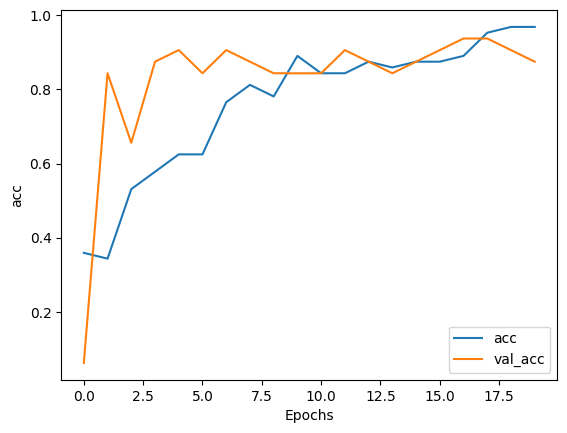

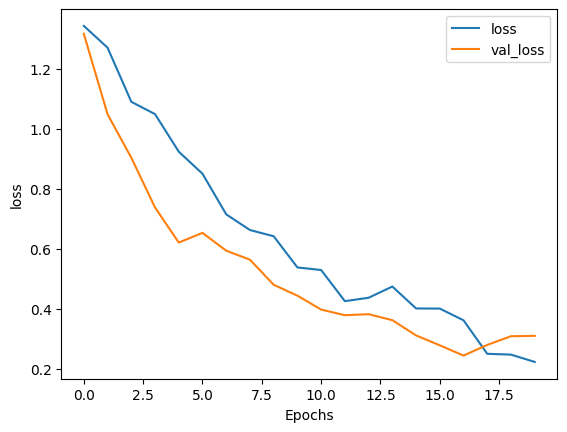

In [36]:
plot_graphs(history_uavid, 'acc')
plot_graphs(history_uavid, 'loss')

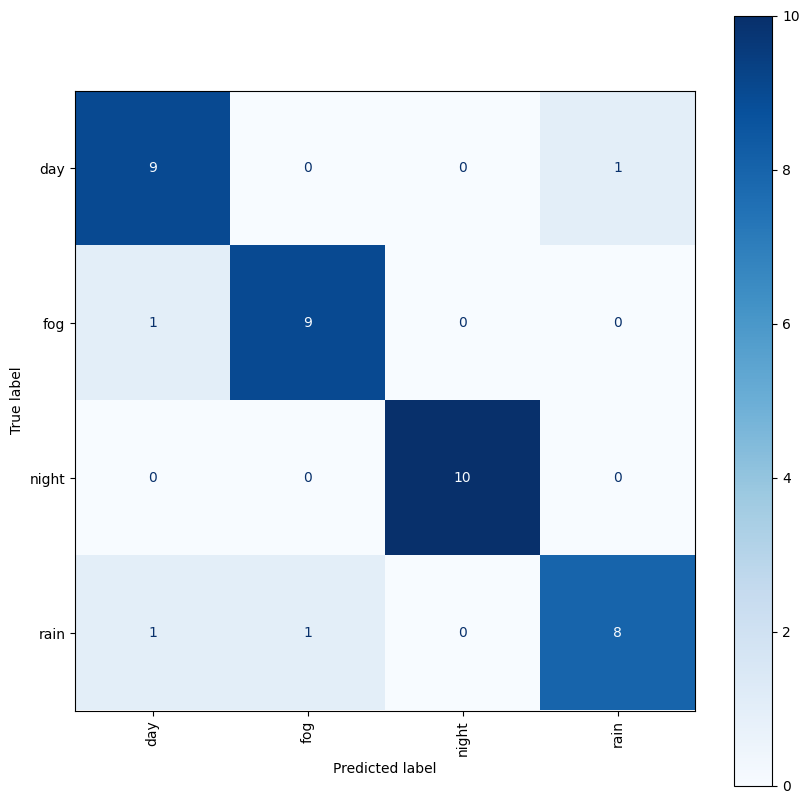

In [37]:
confusion_matrix(np.argmax(test_labels, axis=1), y_pred_uavid, class_labels=label_indices.keys())

In [38]:
report_model(np.argmax(test_labels, axis=1), y_pred_uavid, class_labels=label_indices.keys())

              precision    recall  f1-score   support

         day       0.82      0.90      0.86        10
         fog       0.90      0.90      0.90        10
       night       1.00      1.00      1.00        10
        rain       0.89      0.80      0.84        10

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40
